The idea is to create features that include many stocks, and targets that are the future prices for a range of days, as well as the OHLC for each of those days.

The plan is:
* prototype feature/target creation and neural net with OHLC for a single day
* extend prototype to predict future values for a range of days
* extend prototype to include multiple stocks
* convert to a function
* put in a file and test functions

In [1]:
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np

In [3]:
sorted_old = pd.read_csv('old_good_sorted_by_ewm.csv')

In [4]:
top_stocks = sorted_old.loc[:100, 'ticker'].tolist() + ['SPY', 'UPRO', 'QQQ', 'TQQQ', 'DIA', 'UBT']

In [5]:
top_stocks

['GGP',
 'LNG',
 'AKS',
 'CHK',
 'AMD',
 'CAR',
 'OLED',
 'INCY',
 'SIRI',
 'SWKS',
 'MT',
 'MU',
 'NKTR',
 'X',
 'ETFC',
 'FCX',
 'VRX',
 'REGN',
 'WDC',
 'VRTX',
 'URI',
 'CY',
 'RIG',
 'MSCC',
 'AIG',
 'AKAM',
 'RRC',
 'MGM',
 'ANDV',
 'SWN',
 'TER',
 'NVDA',
 'WMB',
 'BBY',
 'LRCX',
 'GG',
 'FFIV',
 'STLD',
 'ALXN',
 'NOV',
 'NTAP',
 'RIO',
 'PHM',
 'BKNG',
 'ABX',
 'DHI',
 'ADSK',
 'CELG',
 'BMRN',
 'SIG',
 'CGNX',
 'MOS',
 'TTWO',
 'RCL',
 'HIG',
 'ASML',
 'LEN',
 'MS',
 'JNPR',
 'AMAT',
 'AABA',
 'PXD',
 'CTXS',
 'HP',
 'BIIB',
 'HOLX',
 'SBAC',
 'EA',
 'HAL',
 'AMZN',
 'MNST',
 'HFC',
 'KLAC',
 'AMTD',
 'C',
 'KMX',
 'COG',
 'ALK',
 'LNC',
 'RHT',
 'NEM',
 'SCHW',
 'SIVB',
 'VLO',
 'APC',
 'DVN',
 'BHP',
 'IVZ',
 'M',
 'ADBE',
 'AAPL',
 'TOL',
 'COHR',
 'GLW',
 'SYMC',
 'APA',
 'ATVI',
 'JWN',
 'NVR',
 'COF',
 'ADI',
 'SPY',
 'UPRO',
 'QQQ',
 'TQQQ',
 'DIA',
 'UBT']

In [6]:
# prototype with 5 stocks so it will run fast
top_stocks = top_stocks[:5]

In [7]:
top_stocks

['GGP', 'LNG', 'AKS', 'CHK', 'AMD']

# prototype feat/targ creation and neural net with OHLC for single day

ideas:
* use TAs (especially those are scaled to a bound range)
* for anything not scaled to a bound range, take a few lagged time percent differences, e.g. 1, 2, 3, 5, 10, 20, 30, 50, 100 day differences (especially OHLCV) -- scaled by the earliest value
* predict % changed OHLCV for range of days, 1-10.  scale by earliest value

# feat/targ for OHLC for single day future and single day history

In [8]:
import sys
sys.path.append('../code')
import data_processing as dp

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/usr/local/lib/python3.6/dist-packages/odo/backends/pandas.py:94: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access NaTType as type(pandas.NaT)
  @convert.register((pd.Timestamp, pd.Timedelta), (pd.tslib.NaTType, type(None)))


In [9]:
dfs, _, _ = dp.load_stocks(stocks=top_stocks,
                           finra_shorts=False,
                           short_interest=False,
                           earliest_date=None,
                           calc_scores=False)

loading stocks...
calculating TAs...


In [10]:
earliest_dates = []
for s in dfs.keys():
    earliest_dates.append(dfs[s].index.min())

In [11]:
max(earliest_dates)

Timestamp('1994-04-04 00:00:00')

In [12]:
# for now, abbreviate stocks to the latest date
for s in dfs.keys():
    dfs[s] = dfs[s][dfs[s].index > max(earliest_dates)]

In [13]:
# double check that the shapes are the same
for s in dfs.keys():
    print(dfs[s].shape)

(6032, 148)
(6032, 148)
(6032, 148)
(6032, 148)
(6032, 148)


In [14]:
dfs['GGP'].head()

,Ticker,Open,High,Low,Close,Volume,Dividend,Split,Adj_Open,Adj_High,...,ht_ph_cl,ht_ph_tp,ht_q_cl,ht_q_tp,ht_s_cl,ht_s_tp,ht_ls_cl,ht_ls_tp,ht_tr_cl,ht_tr_tp
Date,,,,,,,,,,,,,,,,,,,,,
1994-04-05,GGP,20.13,20.75,20.13,20.75,67767.0,0.0,1.0,1.817687,1.873671,...,-0.040667,0.038746,0.474971,0.438112,0.996578,0.962965,0.763131,0.490263,0,0
1994-04-06,GGP,20.63,20.75,20.50,20.50,13067.0,0.0,1.0,1.858996,1.869809,...,0.321344,0.298467,0.459384,0.373612,0.956550,0.799448,0.470213,0.140511,0,0
1994-04-07,GGP,20.63,20.63,20.38,20.38,9700.0,0.0,1.0,1.861951,1.861951,...,0.389783,0.379353,-0.111125,-0.060209,0.786224,0.537887,0.118994,-0.215760,0,0
1994-04-08,GGP,20.25,20.25,19.75,19.88,35500.0,0.0,1.0,1.828820,1.828820,...,0.215723,0.247969,-0.418478,-0.368066,0.369297,0.029343,-0.395990,-0.686054,0,0
1994-04-11,GGP,19.88,20.13,19.75,20.00,74667.0,0.0,1.0,1.792479,1.815020,...,-0.027317,0.035199,-0.392423,-0.440512,-0.698357,-0.621102,-0.999924,-0.993366,1,0


In [15]:
dfs['GGP'].columns.tolist()

['Ticker',
 'Open',
 'High',
 'Low',
 'Close',
 'Volume',
 'Dividend',
 'Split',
 'Adj_Open',
 'Adj_High',
 'Adj_Low',
 'Adj_Close',
 'Adj_Volume',
 'typical_price',
 'bband_u_cl',
 'bband_m_cl',
 'bband_l_cl',
 'bband_u_cl_diff',
 'bband_m_cl_diff',
 'bband_l_cl_diff',
 'bband_u_cl_diff_hi',
 'bband_l_cl_diff_lo',
 'bband_u_tp',
 'bband_m_tp',
 'bband_l_tp',
 'bband_u_tp_diff',
 'bband_m_tp_diff',
 'bband_l_tp_diff',
 'bband_u_tp_diff_hi',
 'bband_l_tp_diff_lo',
 'dema_cl',
 'dema_tp',
 'dema_cl_diff',
 'dema_tp_diff',
 'ema_cl',
 'ema_tp',
 'ema_cl_diff',
 'ema_tp_diff',
 'ht_tl_cl',
 'ht_tl_tp',
 'ht_tl_cl_diff',
 'ht_tl_tp_diff',
 'kama_cl',
 'kama_tp',
 'kama_cl_diff',
 'kama_tp_diff',
 'mavp_cl',
 'mavp_tp',
 'mavp_cl_diff',
 'mavp_tp_diff',
 'midp_cl',
 'midp_tp',
 'midp_cl_diff',
 'midp_tp_diff',
 'midpr',
 'midpr_diff',
 'sar',
 'sar_diff',
 'sma_10_cl',
 'sma_10_tp',
 'sma_20_cl',
 'sma_20_tp',
 'sma_30_cl',
 'sma_30_tp',
 'sma_40_cl',
 'sma_40_tp',
 'tema_cl',
 'tema_tp',
 '

In [16]:
# drop non-adjusted columns and div/split
dropcols = ['Open', 'High', 'Low', 'Close', 'Volume', 'Dividend', 'Split']
for s in dfs.keys():
    dfs[s].drop(dropcols, axis=1, inplace=True)

In [17]:
# scale all moving averages by typical price in past

In [18]:
# find TAS not bound to range -- from EDA short data 1-2-2018.ipynb file

# columns to ignore because they have large outliers that can't really be ignored
ignore_cols = set(['Open',
                    'Close',
                    'Low', 
                    'High',
                    'Volume',
                    'Dividend',
                    'Split',
                    'bband_u_cl',
                    'bband_m_cl',
                    'bband_l_cl',
                    'bband_u_tp',
                    'bband_m_tp',
                    'bband_l_tp',
                    'dema_cl',
                    'dema_tp',
                    'ema_cl',
                    'ema_tp',
                    'ht_tl_cl',
                    'ht_tl_tp',
                    'kama_cl',
                    'kama_tp',
                    'mavp_cl',
                    'mavp_tp',
                    'midp_cl',
                    'midp_tp',
                    'midpr',
                    'sar',
                    'sma_10_cl',
                    'sma_10_tp',
                    'sma_20_cl',
                    'sma_20_tp',
                    'sma_30_cl',
                    'sma_30_tp',
                    'sma_40_cl',
                    'sma_40_tp',
                    'tema_cl',
                    'tema_tp',
                    'trima_cl',
                    'trima_tp',
                    'wma_cl',
                    'wma_tp',
                    'mdm',
                    'pldm',
                    'rocr_cl_100', # already have the same data /100 as rocr
                    'rocr_tp_100',
                    'atr',
                    'natr',
                    'trange',
                    'Shares_Float',
                    'Shares_Outstanding',
                    'Avg._Daily_Vol.',
                    'Ticker'])

keep_cols = [c for c in dfs['GGP'].columns.tolist() if c not in ignore_cols]

In [19]:
keep_cols

['Adj_Open',
 'Adj_High',
 'Adj_Low',
 'Adj_Close',
 'Adj_Volume',
 'typical_price',
 'bband_u_cl_diff',
 'bband_m_cl_diff',
 'bband_l_cl_diff',
 'bband_u_cl_diff_hi',
 'bband_l_cl_diff_lo',
 'bband_u_tp_diff',
 'bband_m_tp_diff',
 'bband_l_tp_diff',
 'bband_u_tp_diff_hi',
 'bband_l_tp_diff_lo',
 'dema_cl_diff',
 'dema_tp_diff',
 'ema_cl_diff',
 'ema_tp_diff',
 'ht_tl_cl_diff',
 'ht_tl_tp_diff',
 'kama_cl_diff',
 'kama_tp_diff',
 'mavp_cl_diff',
 'mavp_tp_diff',
 'midp_cl_diff',
 'midp_tp_diff',
 'midpr_diff',
 'sar_diff',
 'tema_cl_diff',
 'tema_tp_diff',
 'trima_cl_diff',
 'trima_tp_diff',
 'wma_cl_diff',
 'wma_tp_diff',
 'adx',
 'adxr',
 'apo_cl',
 'apo_tp',
 'arup',
 'ardn',
 'aroonosc',
 'bop',
 'cci',
 'cmo_cl',
 'cmo_tp',
 'dx',
 'macd_cl',
 'macdsignal_cl',
 'macdhist_cl',
 'macd_tp',
 'macdsignal_tp',
 'macdhist_tp',
 'mfi',
 'mdi',
 'mom_cl',
 'mom_tp',
 'pldi',
 'ppo_cl',
 'ppo_tp',
 'roc_cl',
 'roc_tp',
 'rocp_cl',
 'rocp_tp',
 'rocr_cl',
 'rocr_tp',
 'rsi_cl',
 'rsi_tp',
 

In [20]:
dfs_full = dfs.copy()

In [21]:
for s in dfs:
    dfs[s] = dfs[s].iloc[-100:]

In [22]:
# create time-lagged percent difference features for OHLCV (and maybe eventually TAs) not bound to a range
periods = [1, 2, 3]#, 5, 10, 20, 30, 50, 100]

cols = ['Adj_Open', 'Adj_Close', 'Adj_High', 'Adj_Low', 'Adj_Volume', 'typical_price']
pct_change_dict = {}
for c in cols:
    for p in periods:
        pct_change_dict[c + '_pct_change_p=' + str(p)] = []

s = 'GGP'
for i, (index, r) in enumerate(dfs[s].iterrows()):
    for c in cols:
        for p in periods:
            if i >= p: # if on day 2 (index 1), then the lag would be current - 0
                old = dfs[s][c].iloc[i-p]
                new = dfs[s][c].iloc[i]
                pct_change = (new - old) / old
                pct_change_dict[c + '_pct_change_p=' + str(p)].append(pct_change)
            else:
                pct_change_dict[c + '_pct_change_p=' + str(p)].append(np.nan)

In [23]:
dfs[s]

,Ticker,Adj_Open,Adj_High,Adj_Low,Adj_Close,Adj_Volume,typical_price,bband_u_cl,bband_m_cl,bband_l_cl,...,ht_ph_cl,ht_ph_tp,ht_q_cl,ht_q_tp,ht_s_cl,ht_s_tp,ht_ls_cl,ht_ls_tp,ht_tr_cl,ht_tr_tp
Date,,,,,,,,,,,,,,,,,,,,,
2017-10-24,GGP,21.131497,21.161218,20.665871,20.685685,4736699.0,21.033333,21.837798,21.362,20.886202,...,-0.118710,-0.087937,-0.331993,-0.312139,-0.756759,-0.681792,-0.997341,-0.999381,0,0
2017-10-25,GGP,20.487547,20.665871,20.007060,20.398384,6279730.0,20.548333,21.866844,21.253,20.639156,...,-0.224229,-0.153740,-0.314606,-0.252030,-0.916244,-0.872840,-0.931164,-0.962264,1,0
2017-10-26,GGP,20.715406,20.725313,19.987246,20.259687,6814440.0,20.515000,21.911463,21.152,20.392537,...,-0.332338,-0.248066,-0.110021,-0.189892,-0.998050,-0.987626,-0.749864,-0.809249,1,1
2017-10-27,GGP,20.170525,20.170525,19.615736,19.764340,10249372.0,20.036667,21.947704,20.981,20.014296,...,-0.271333,-0.265860,0.041764,-0.080157,-0.966212,-0.983939,-0.500959,-0.569530,1,1
2017-10-30,GGP,19.744526,20.066502,19.744526,19.764340,8055838.0,20.045000,21.918068,20.831,19.743932,...,-0.212713,-0.231771,-0.132860,-0.119416,-0.857084,-0.891672,-0.241765,-0.310412,1,1
2017-10-31,GGP,19.734619,19.813875,18.684484,19.278900,12046720.0,19.440000,21.859774,20.620,19.380226,...,-0.299550,-0.269618,-0.599788,-0.555584,-0.716457,-0.758750,-0.013312,-0.075921,1,1
2017-11-01,GGP,19.318528,19.516667,19.219459,19.259086,6865644.0,19.513333,21.805212,20.446,19.086788,...,-0.621752,-0.598781,-0.656296,-0.701856,-0.661030,-0.700917,0.063166,0.008716,1,1
2017-11-02,GGP,19.249179,19.546387,19.160017,19.486946,6405347.0,19.580000,21.599312,20.287,18.974688,...,-0.735740,-0.745727,-0.540769,-0.511242,-0.603545,-0.644442,0.137026,0.085002,1,1
2017-11-03,GGP,19.288807,19.358255,18.654763,18.922250,11541692.0,19.156700,21.422565,20.080,18.737435,...,-0.938589,-0.888912,-0.446336,-0.407187,-0.557481,-0.597130,0.192834,0.144967,1,1


In [24]:
pct_change_dict

{'Adj_Close_pct_change_p=1': [nan,
  -0.01388888888888893,
  -0.006799417192812119,
  -0.02444987775061114,
  0.0,
  -0.024561403508771926,
  -0.0010277492291880367,
  0.011831275720164592,
  -0.02897813929842401,
  -0.004712041884816658,
  0.16780641767490784,
  -0.019819819819819826,
  0.011029411764705932,
  0.009090909090909049,
  0.08333333333333327,
  -0.004158004158004139,
  -0.004175365344467472,
  0.0029350104821802498,
  -0.010869565217391764,
  -0.009721048182586635,
  -0.0034144259496367746,
  -0.0004282655246254807,
  0.0004284490145674797,
  -0.004710920770877984,
  0.004733218588640315,
  0.002141327623126175,
  0.004273504273504255,
  0.0038297872340427802,
  0.0016956337431112672,
  -0.0038087177316970693,
  -0.0059473237043329635,
  0.0,
  0.0012820512820510006,
  -0.0017072129748182342,
  0.01624625908507905,
  -0.003365586874211055,
  -0.0021105951878431133,
  -0.0046968403074296745,
  -0.0012870012870011835,
  0.0038659793814432926,
  -0.011553273427471098,
  -0.00

In [25]:
dfs[s] = dfs[s].assign(**pct_change_dict)

In [26]:
(dfs[s].iloc[2]['Adj_Close'] - dfs[s].iloc[1]['Adj_Close'])/ dfs[s].iloc[1]['Adj_Close']

-0.006799417192812119

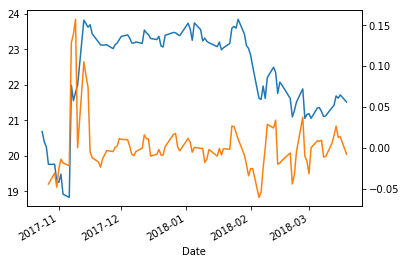

In [27]:
dfs[s]['Adj_Close'].plot()
dfs[s]['Adj_Close_pct_change_p=3'].plot(secondary_y=True)

In [28]:
# now create future targets...% change OHLCV
future_days = list(range(1, 11))

In [29]:
future_days

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [30]:
dfs[s].shape[0]  # can only access up to shape - 1

100

In [31]:
pct_change_dict = {}
for c in cols:
    for f in future_days:
        pct_change_dict[c + '_pct_change_f=' + str(f)] = []

last_idx = dfs[s].shape[0] - 1
for i, (index, r) in enumerate(dfs[s].iterrows()):
    for c in cols:
        for f in future_days:
            if i + f <= last_idx: # if on day 2 (index 1), then the lag would be current - 0
                old = dfs[s][c].iloc[i]
                new = dfs[s][c].iloc[i + f]
                pct_change = (new - old) / old
                pct_change_dict[c + '_pct_change_f=' + str(f)].append(pct_change)
            else:
                pct_change_dict[c + '_pct_change_f=' + str(f)].append(np.nan)

In [32]:
dfs[s] = dfs[s].assign(**pct_change_dict)

In [33]:
dfs[s]

,Ticker,Adj_Open,Adj_High,Adj_Low,Adj_Close,Adj_Volume,typical_price,bband_u_cl,bband_m_cl,bband_l_cl,...,typical_price_pct_change_f=1,typical_price_pct_change_f=2,typical_price_pct_change_f=3,typical_price_pct_change_f=4,typical_price_pct_change_f=5,typical_price_pct_change_f=6,typical_price_pct_change_f=7,typical_price_pct_change_f=8,typical_price_pct_change_f=9,typical_price_pct_change_f=10
Date,,,,,,,,,,,,,,,,,,,,,
2017-10-24,GGP,21.131497,21.161218,20.665871,20.685685,4736699.0,21.033333,21.837798,21.362,20.886202,...,-0.023059,-0.024643,-0.047385,-0.046989,-0.075753,-0.072266,-0.069097,-0.089222,-0.089857,0.012995
2017-10-25,GGP,20.487547,20.665871,20.007060,20.398384,6279730.0,20.548333,21.866844,21.253,20.639156,...,-0.001622,-0.024901,-0.024495,-0.053938,-0.050369,-0.047125,-0.067725,-0.068375,0.036905,0.062130
2017-10-26,GGP,20.715406,20.725313,19.987246,20.259687,6814440.0,20.515000,21.911463,21.152,20.392537,...,-0.023316,-0.022910,-0.052401,-0.048826,-0.045576,-0.066210,-0.066862,0.038590,0.063856,0.071899
2017-10-27,GGP,20.170525,20.170525,19.615736,19.764340,10249372.0,20.036667,21.947704,20.981,20.014296,...,0.000416,-0.029779,-0.026119,-0.022792,-0.043918,-0.044585,0.063384,0.089253,0.097488,0.103976
2017-10-30,GGP,19.744526,20.066502,19.744526,19.764340,8055838.0,20.045000,21.918068,20.831,19.743932,...,-0.030182,-0.026524,-0.023198,-0.044315,-0.044982,0.062942,0.088800,0.097032,0.103517,0.191320
2017-10-31,GGP,19.734619,19.813875,18.684484,19.278900,12046720.0,19.440000,21.859774,20.620,19.380226,...,0.003772,0.007202,-0.014573,-0.015261,0.096022,0.122685,0.131173,0.137860,0.228395,0.231139
2017-11-01,GGP,19.318528,19.516667,19.219459,19.259086,6865644.0,19.513333,21.805212,20.446,19.086788,...,0.003416,-0.018276,-0.018961,0.091903,0.118466,0.126922,0.133584,0.223779,0.226512,0.218141
2017-11-02,GGP,19.249179,19.546387,19.160017,19.486946,6405347.0,19.580000,21.599312,20.287,18.974688,...,-0.021619,-0.022302,0.088185,0.114658,0.123085,0.129724,0.219612,0.222336,0.213994,0.219101
2017-11-03,GGP,19.288807,19.358255,18.654763,18.922250,11541692.0,19.156700,21.422565,20.080,18.737435,...,-0.000698,0.112231,0.139288,0.147901,0.154687,0.246561,0.249345,0.240819,0.246039,0.240993


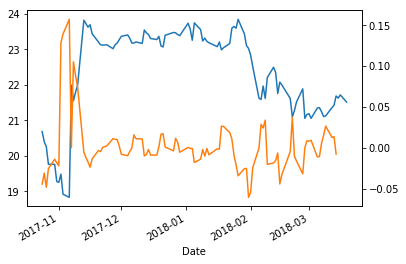

In [34]:
dfs[s]['Adj_Close'].plot()
dfs[s]['Adj_Close_pct_change_f=3'].plot(secondary_y=True)

In [35]:
# now we want to drop everything where we don't have data (nans) and remove the original unbounded columns
dfs[s].drop(cols, inplace=True, axis=1)

In [36]:
dfs[s].dropna(inplace=True)

In [37]:
def drop_cols(dfs):
    # find TAS not bound to range -- from EDA short data 1-2-2018.ipynb file

    # columns to ignore because they have large outliers that can't really be ignored
    ignore_cols = set(['Open',
                        'Close',
                        'Low', 
                        'High',
                        'Volume',
                        'Dividend',
                        'Split',
                        'bband_u_cl',
                        'bband_m_cl',
                        'bband_l_cl',
                        'bband_u_tp',
                        'bband_m_tp',
                        'bband_l_tp',
                        'dema_cl',
                        'dema_tp',
                        'ema_cl',
                        'ema_tp',
                        'ht_tl_cl',
                        'ht_tl_tp',
                        'kama_cl',
                        'kama_tp',
                        'mavp_cl',
                        'mavp_tp',
                        'midp_cl',
                        'midp_tp',
                        'midpr',
                        'sar',
                        'sma_10_cl',
                        'sma_10_tp',
                        'sma_20_cl',
                        'sma_20_tp',
                        'sma_30_cl',
                        'sma_30_tp',
                        'sma_40_cl',
                        'sma_40_tp',
                        'tema_cl',
                        'tema_tp',
                        'trima_cl',
                        'trima_tp',
                        'wma_cl',
                        'wma_tp',
                        'mdm',
                        'pldm',
                        'rocr_cl_100', # already have the same data /100 as rocr
                        'rocr_tp_100',
                        'atr',
                        'natr',
                        'trange',
                        'Shares_Float',
                        'Shares_Outstanding',
                        'Avg._Daily_Vol.',
                        'Ticker'])

    first = list(dfs.keys())[0]
    keep_cols = [c for c in dfs[first].columns.tolist() if c not in ignore_cols]
    for s in dfs.keys():
        dfs[s] = dfs[s][keep_cols]

In [38]:
# create a function and test to see if result is the same
def make_ohlcv_feats_targs(dfs, past_periods=[1, 2, 3, 5, 10, 20, 30, 50, 100], future_days=range(1, 11)):
    epsilon = 0.001
    for s in dfs.keys():
        # create time-lagged percent difference features for OHLCV (and maybe eventually TAs) not bound to a range
        cols = ['Adj_Open', 'Adj_Close', 'Adj_High', 'Adj_Low', 'Adj_Volume', 'typical_price']
        pct_change_dict = {}
        for c in cols:
            for p in past_periods:
                pct_change_dict[c + '_pct_change_p=' + str(p)] = []

        for i, (index, r) in enumerate(dfs[s].iterrows()):
            for c in cols:
                for p in past_periods:
                    if i >= p: # if on day 2 (index 1), then the lag would be current - 0
                        old = dfs[s][c].iloc[i-p] + epsilon
                        new = dfs[s][c].iloc[i]
                        pct_change = (new - old) / old
                        pct_change_dict[c + '_pct_change_p=' + str(p)].append(pct_change)
                    else:
                        pct_change_dict[c + '_pct_change_p=' + str(p)].append(np.nan)
        
        # add to dataframe
        dfs[s] = dfs[s].assign(**pct_change_dict)

        # create future targets for each of future_days
        cols = ['Adj_Open', 'Adj_Close', 'Adj_High', 'Adj_Low', 'Adj_Volume']
        pct_change_dict = {}
        for c in cols:
            for f in future_days:
                pct_change_dict[c + '_pct_change_f=' + str(f)] = []

        last_idx = dfs[s].shape[0] - 1
        for i, (index, r) in enumerate(dfs[s].iterrows()):
            for c in cols:
                for f in future_days:
                    if i + f <= last_idx: # if on day 2 (index 1), then the lag would be current - 0
                        old = dfs[s][c].iloc[i] + epsilon
                        new = dfs[s][c].iloc[i + f]
                        pct_change = (new - old) / old
                        pct_change_dict[c + '_pct_change_f=' + str(f)].append(pct_change)
                    else:
                        pct_change_dict[c + '_pct_change_f=' + str(f)].append(np.nan)

        # enter into dataframe:
        dfs[s] = dfs[s].assign(**pct_change_dict)
        dfs[s].drop(cols + ['typical_price'], inplace=True, axis=1)
        # no need to return anything, all updates made in-place

In [39]:
# reload data
dfs, _, _ = dp.load_stocks(stocks=top_stocks,
                           finra_shorts=False,
                           short_interest=False,
                           earliest_date=None,
                           calc_scores=False)

loading stocks...
calculating TAs...


In [40]:
dfs_full = dfs.copy()
dfs_full[s].shape

(6282, 148)

In [41]:
drop_cols(dfs)

In [42]:
make_ohlcv_feats_targs(dfs)

In [43]:
dfs[s].shape

(6282, 197)

# prototype neural net for this single-stock data

In [44]:
from keras.layers import Input, Dense, Dropout, BatchNormalization, LSTM, Conv1D, MaxPooling1D, Activation, Flatten, Concatenate, Reshape
from keras.models import Model, load_model
from keras import optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.regularizers import l1_l2
import keras.backend as K
import keras.losses

Using TensorFlow backend.
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [45]:
# first get features and targets, and future data
s = 'GGP'
targ_cols = [c for c in dfs[s].columns if 'f=' in c]
feat_cols = [c for c in dfs[s].columns if c not in set(targ_cols)]

In [46]:
no_missing = dfs[s].dropna()
features = no_missing[feat_cols]
targets = no_missing[targ_cols]

In [47]:
targets.shape

(6172, 50)

In [48]:
features.shape

(6172, 147)

In [49]:
train_size = int(features.shape[0] * 0.8)
train_features = features[:train_size]
test_features = features[train_size:]
train_targets = targets[:train_size]
test_targets = targets[train_size:]

In [50]:
train_features.shape

(4937, 147)

In [51]:
test_features.shape

(1235, 147)

In [52]:
import keras.losses
import tensorflow as tf

def stock_loss_mae_log(y_true, y_pred):
    alpha1 = 3.  # penalty for predicting positive but actual is negative
    alpha2 = 2.  # penalty for predicting negative but actual is positive
    loss = tf.where(K.less(y_true * y_pred, 0), \
                     tf.where(K.less(y_true, y_pred), \
                                alpha1 * K.log(100 * K.abs(y_true - y_pred) + 1), \
                                alpha2 * K.log(100 * K.abs(y_true - y_pred) + 1)), \
                     K.log(100 * K.abs(y_true - y_pred) + 1))

    return K.mean(loss, axis=-1)

def stock_loss_mae_arcsinh(y_true, y_pred):
    # http://reference.wolfram.com/language/ref/ArcSinh.html
    alpha1 = 3.  # penalty for predicting positive but actual is negative
    alpha2 = 2.  # penalty for predicting negative but actual is positive
    z = 100 * K.abs(y_true - y_pred)
    arcsinh = K.log(K.sqrt(K.square(z) + 1) + z)
    loss = tf.where(K.less(y_true * y_pred, 0), \
                    tf.where(K.less(y_true, y_pred), \
                                alpha1 * arcsinh, \
                                alpha2 * arcsinh), \
                    arcsinh)

    return K.mean(loss, axis=-1)


keras.losses.stock_loss_mae_log = stock_loss_mae_log
keras.losses.stock_loss_mae_arcsinh = stock_loss_mae_arcsinh

In [53]:
K.clear_session()

timesteps = 1
input_dim = features.shape[1]
output_dim = targets.shape[1]

inputs = Input(shape=(timesteps*input_dim, ))
x = BatchNormalization()(inputs)
x = Dense(3000, activation='elu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(2000, activation='elu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(1000, activation='elu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(500, activation='elu')(x)
x = BatchNormalization()(x)
x = Dropout(0.1)(x)
x = Dense(100, activation='elu')(x)
x = BatchNormalization()(x)
x = Dense(output_dim, activation='linear')(x)

mod = Model(inputs, x)
mod.compile(optimizer='adam', loss=stock_loss_mae_arcsinh)

In [54]:
history = mod.fit(train_features,
            train_targets,
            epochs=300,
            validation_split=0.1,
            batch_size=2000)

Train on 4443 samples, validate on 494 samples
Epoch 1/300
4443/4443 [==============================] - 1s 288us/step - loss: 8.4287 - val_loss: 8.3782
Epoch 2/300
4443/4443 [==============================] - 0s 21us/step - loss: 7.8732 - val_loss: 7.9769
Epoch 3/300
4443/4443 [==============================] - 0s 21us/step - loss: 7.3016 - val_loss: 7.8250
Epoch 4/300
4443/4443 [==============================] - 0s 21us/step - loss: 6.8485 - val_loss: 7.6232
Epoch 5/300
4443/4443 [==============================] - 0s 22us/step - loss: 6.4961 - val_loss: 7.4770
Epoch 6/300
4443/4443 [==============================] - 0s 22us/step - loss: 6.1744 - val_loss: 7.3796
Epoch 7/300
4443/4443 [==============================] - 0s 21us/step - loss: 5.9059 - val_loss: 7.1263
Epoch 8/300
4443/4443 [==============================] - 0s 21us/step - loss: 5.6600 - val_loss: 7.0751
Epoch 9/300
4443/4443 [==============================] - 0s 21us/step - loss: 5.4495 - val_loss: 6.8584
Epoch 10/300
444

4443/4443 [==============================] - 0s 21us/step - loss: 3.2035 - val_loss: 3.4575
Epoch 156/300
4443/4443 [==============================] - 0s 23us/step - loss: 3.2451 - val_loss: 3.4821
Epoch 157/300
4443/4443 [==============================] - 0s 23us/step - loss: 3.2492 - val_loss: 3.4100
Epoch 158/300
4443/4443 [==============================] - 0s 22us/step - loss: 3.2083 - val_loss: 3.4315
Epoch 159/300
4443/4443 [==============================] - 0s 21us/step - loss: 3.2194 - val_loss: 3.3468
Epoch 160/300
4443/4443 [==============================] - 0s 22us/step - loss: 3.1823 - val_loss: 3.3838
Epoch 161/300
4443/4443 [==============================] - 0s 23us/step - loss: 3.2287 - val_loss: 3.4282
Epoch 162/300
4443/4443 [==============================] - 0s 22us/step - loss: 3.2934 - val_loss: 3.4121
Epoch 163/300
4443/4443 [==============================] - 0s 22us/step - loss: 3.2121 - val_loss: 3.3681
Epoch 164/300
4443/4443 [==============================] - 0

In [55]:
import matplotlib.pyplot as plt
%matplotlib inline

Text(0,0.5,'val loss')

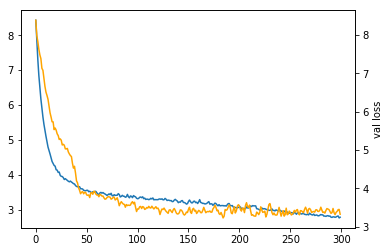

In [56]:
fig, ax1 = plt.subplots()
_ = ax1.plot(history.history['loss'])
ax2 = ax1.twinx()
_ = ax2.plot(history.history['val_loss'], c='orange')
ax2.set_ylabel('val loss')

In [57]:
train_predictions = mod.predict(train_features)

In [58]:
targ_cols

['Adj_Open_pct_change_f=1',
 'Adj_Open_pct_change_f=2',
 'Adj_Open_pct_change_f=3',
 'Adj_Open_pct_change_f=4',
 'Adj_Open_pct_change_f=5',
 'Adj_Open_pct_change_f=6',
 'Adj_Open_pct_change_f=7',
 'Adj_Open_pct_change_f=8',
 'Adj_Open_pct_change_f=9',
 'Adj_Open_pct_change_f=10',
 'Adj_Close_pct_change_f=1',
 'Adj_Close_pct_change_f=2',
 'Adj_Close_pct_change_f=3',
 'Adj_Close_pct_change_f=4',
 'Adj_Close_pct_change_f=5',
 'Adj_Close_pct_change_f=6',
 'Adj_Close_pct_change_f=7',
 'Adj_Close_pct_change_f=8',
 'Adj_Close_pct_change_f=9',
 'Adj_Close_pct_change_f=10',
 'Adj_High_pct_change_f=1',
 'Adj_High_pct_change_f=2',
 'Adj_High_pct_change_f=3',
 'Adj_High_pct_change_f=4',
 'Adj_High_pct_change_f=5',
 'Adj_High_pct_change_f=6',
 'Adj_High_pct_change_f=7',
 'Adj_High_pct_change_f=8',
 'Adj_High_pct_change_f=9',
 'Adj_High_pct_change_f=10',
 'Adj_Low_pct_change_f=1',
 'Adj_Low_pct_change_f=2',
 'Adj_Low_pct_change_f=3',
 'Adj_Low_pct_change_f=4',
 'Adj_Low_pct_change_f=5',
 'Adj_Low_pc

In [59]:
train_predictions[0]

array([ 0.01109944,  0.00661624,  0.00745611,  0.00276502, -0.00107945,
       -0.00111898, -0.00486633,  0.00103563, -0.00171683,  0.00170711,
        0.00089846, -0.00254391, -0.00824916, -0.01081215, -0.01084589,
       -0.01302172, -0.01213488, -0.01212022, -0.00738964, -0.00731229,
        0.00132452, -0.00237002, -0.0057877 , -0.00656675, -0.01177547,
       -0.01115988, -0.01046907, -0.00874914, -0.00610716, -0.00829032,
        0.00224465,  0.00172669, -0.00031178, -0.00361418, -0.00505618,
       -0.0046004 , -0.0041416 ,  0.00057448, -0.0025424 ,  0.00198295,
       -0.00657847, -0.01353883, -0.00671499, -0.00377834, -0.01250831,
       -0.00763115, -0.01198731, -0.0088377 , -0.00388808, -0.02705665],
      dtype=float32)

In [60]:
from sklearn.metrics import r2_score as r2

0.19506328487720792


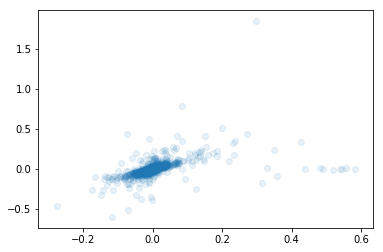

In [61]:
adj_open_f_1_preds = train_predictions[:, 0]
adj_open_f_1_actual = train_targets.iloc[:, 0]
print(r2(adj_open_f_1_actual, adj_open_f_1_preds))
_ = plt.scatter(adj_open_f_1_preds, adj_open_f_1_actual, alpha=0.1)

-0.23383819747931756


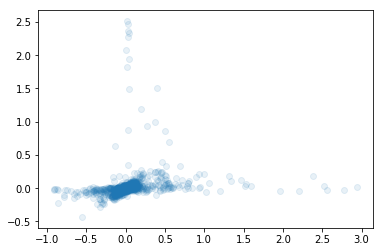

In [62]:
adj_open_f_9_preds = train_predictions[:, 8]
adj_open_f_9_actual = train_targets.iloc[:, 8]
print(r2(adj_open_f_9_actual, adj_open_f_9_preds))
_ = plt.scatter(adj_open_f_9_actual, adj_open_f_9_preds, alpha=0.1)

0.148701950245968


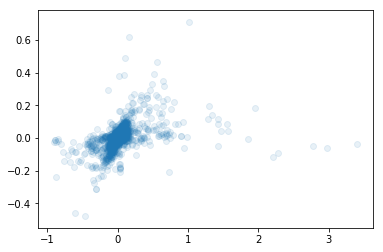

In [63]:
adj_open_f_10_preds = train_predictions[:, 9]
adj_open_f_10_actual = train_targets.iloc[:, 9]
print(r2(adj_open_f_10_actual, adj_open_f_10_preds))
_ = plt.scatter(adj_open_f_10_actual, adj_open_f_10_preds, alpha=0.1)

0.148701950245968


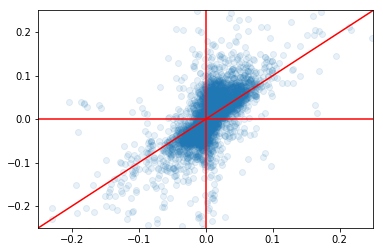

In [64]:
adj_open_f_10_preds = train_predictions[:, 9]
adj_open_f_10_actual = train_targets.iloc[:, 9]
print(r2(adj_open_f_10_actual, adj_open_f_10_preds))
_ = plt.scatter(adj_open_f_10_preds, adj_open_f_10_actual, alpha=0.1)
_ = plt.xlim([-0.25, 0.25])
_ = plt.ylim([-0.25, 0.25])
_ = plt.axhline(0, c='r')
_ = plt.axvline(0, c='r')
lines = np.array(range(-26, 26)) / 10
plt.plot(lines, lines, c='r')

0.13243754882997205


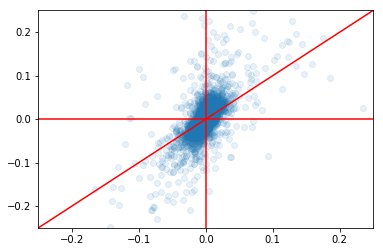

In [65]:
adj_open_f_1_preds = train_predictions[:, 0]
adj_open_f_1_actual = train_targets.iloc[:, 1]
print(r2(adj_open_f_1_actual, adj_open_f_1_preds))
_ = plt.scatter(adj_open_f_1_preds, adj_open_f_1_actual, alpha=0.1)
_ = plt.xlim([-0.25, 0.25])
_ = plt.ylim([-0.25, 0.25])
_ = plt.axhline(0, c='r')
_ = plt.axvline(0, c='r')
lines = np.array(range(-26, 26)) / 10
plt.plot(lines, lines, c='r')

0.13955886933412343


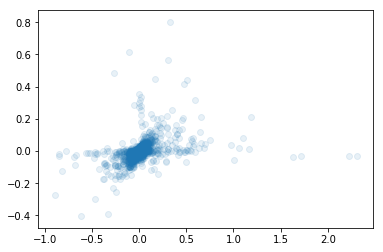

In [66]:
adj_open_f_5_preds = train_predictions[:, 4]
adj_open_f_5_actual = train_targets.iloc[:, 4]
print(r2(adj_open_f_5_actual, adj_open_f_5_preds))
_ = plt.scatter(adj_open_f_5_actual, adj_open_f_5_preds, alpha=0.1)

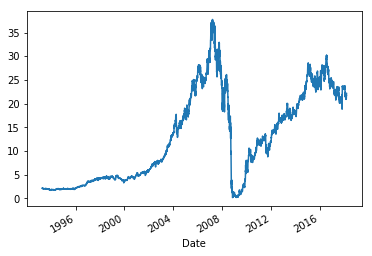

In [67]:
_ = dfs_full[s]['Adj_Open'].plot()

In [68]:
s

'GGP'

In [69]:
adj_open_f_9_preds.shape

(4937,)

In [70]:
r

Ticker                                  GGP
Adj_Open                              22.14
Adj_High                              22.25
Adj_Low                               21.31
Adj_Close                             21.52
Adj_Volume                      6.49065e+06
typical_price                       21.6933
bband_u_cl                          21.8364
bband_m_cl                            21.42
bband_l_cl                          21.0036
bband_u_cl_diff                    0.316365
bband_m_cl_diff                        -0.1
bband_l_cl_diff                   -0.516365
bband_u_cl_diff_hi                -0.413635
bband_l_cl_diff_lo                -0.306365
bband_u_tp                          21.8421
bband_m_tp                          21.4046
bband_l_tp                          20.9671
bband_u_tp_diff                     0.14875
bband_m_tp_diff                    -0.28875
bband_l_tp_diff                    -0.72625
bband_u_tp_diff_hi                -0.407917
bband_l_tp_diff_lo              

In [71]:
targ_cols[9]

'Adj_Open_pct_change_f=10'

In [72]:
# back-calculate future prices to make sure everything is good
ggp_df = dfs_full[s].copy()
f9_open_actual = []
f9_open_prediction = []
indices = []
for i, (index, r) in enumerate(train_targets.iterrows()):
    indices.append(index)
    if i + 9 <= train_targets.shape[0] - 1:
        change = r['Adj_Open_pct_change_f=9']
        cur = ggp_df.loc[index]['Adj_Open']
        fut = cur * (change + 1)
        fut_pred = cur * (train_predictions[i, 8] + 1)
        f9_open_actual.append(fut)
        f9_open_prediction.append(fut_pred)

indices = indices[9:]

In [73]:
len(f9_open_actual)

4928

In [74]:
len(indices)

4928

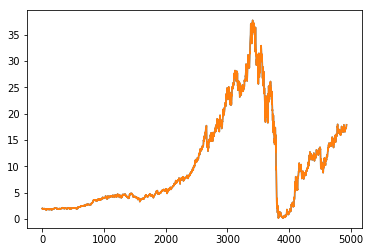

In [75]:
_ = plt.plot(f9_open_actual)
_ = plt.plot(dfs_full[s].loc[indices]['Adj_Open'].values)

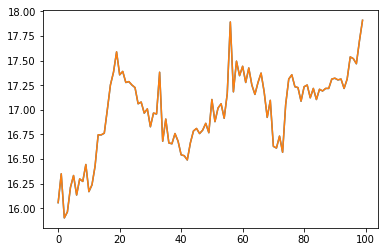

In [76]:
_ = plt.plot(f9_open_actual[-100:])
_ = plt.plot(dfs_full[s].loc[indices]['Adj_Open'].values[-100:])

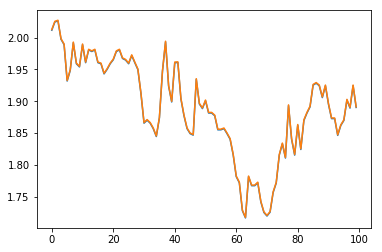

In [77]:
_ = plt.plot(f9_open_actual[:100])
_ = plt.plot(dfs_full[s].loc[indices]['Adj_Open'].values[:100])

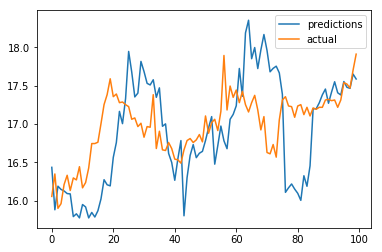

In [78]:
_ = plt.plot(f9_open_prediction[-100:], label='predictions')
_ = plt.plot(dfs_full[s].loc[indices]['Adj_Open'].values[-100:], label='actual')
_ = plt.legend()

In [79]:
np.allclose(f9_open_actual, dfs_full[s].loc[indices]['Adj_Open'].values, 0.01)

True

In [80]:
np.sum(f9_open_actual - dfs_full[s].loc[indices]['Adj_Open'].values)

-4.994558043894218

In [81]:
t = np.where(abs(f9_open_actual - dfs_full[s].loc[indices]['Adj_Open'].values) > 0.001)[0]

In [82]:
len(t)

2800

In [83]:
f9_open_actual - dfs_full[s].loc[indices]['Adj_Open'].values

array([-0.00101124, -0.0010028 , -0.00099805, ..., -0.00101452,
       -0.00102244, -0.00103392])

# now combine data from many stocks into one feature/target set (need to be careful to keep labels straight)

In [84]:
# reload data to start from scratch
dfs, _, _ = dp.load_stocks(stocks=top_stocks,
                           finra_shorts=False,
                           short_interest=False,
                           earliest_date=None,
                           calc_scores=False)

loading stocks...
calculating TAs...


In [85]:
def get_latest_earliest_date(dfs, verbose=False):
    earliest_dates = []
    for s in dfs.keys():
        earliest_date = dfs[s].index.min()
        if verbose:
            print(s, earliest_date)
            
        earliest_dates.append(earliest_date)
    
    return max(earliest_dates)

In [86]:
latest_date = get_latest_earliest_date(dfs)
for s in dfs.keys():
    # standardize to latest date so they all have the same earliest time
    dfs[s] = dfs[s][dfs[s].index > latest_date]

In [87]:
drop_cols(dfs)
make_ohlcv_feats_targs(dfs)

In [88]:
# first get features and targets, and future data
s = list(dfs.keys())[0]
targ_cols = [c for c in dfs[s].columns if 'f=' in c]
feat_cols = [c for c in dfs[s].columns if c not in set(targ_cols)]

In [89]:
stocks = []
feat_labels = []
targ_labels = []
features = None
for s in dfs.keys():
    stocks.append(s)
    no_missing = dfs[s].dropna()
    s_features = no_missing[feat_cols]
    feat_labels.extend(s_features.columns.tolist())
    s_targets = no_missing[targ_cols]
    targ_labels.extend(s_targets.columns.tolist())
    if features is None:
        features = s_features.values
        targets = s_targets.values
    else:
        features = np.hstack((features, s_features))
        targets = np.hstack((targets, s_targets))

In [90]:
# for i in range(targets.shape[1]):
#     _ = plt.hist(targets[:, 1], bins=50)
#     plt.show()

In [94]:
stocks

['GGP', 'LNG', 'AKS', 'CHK', 'AMD']

In [95]:
s_features.shape

(5922, 147)

In [96]:
features.shape

(5922, 735)

In [97]:
train_size = int(features.shape[0] * 0.8)
train_features = features[:train_size]
test_features = features[train_size:]
train_targets = targets[:train_size]
test_targets = targets[train_size:]

In [98]:
K.clear_session()

timesteps = 1
input_dim = features.shape[1]
output_dim = targets.shape[1]

inputs = Input(shape=(timesteps*input_dim, ))
x = BatchNormalization()(inputs)
x = Dense(3000, activation='elu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(2000, activation='elu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(1000, activation='elu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(500, activation='elu')(x)
x = BatchNormalization()(x)
x = Dropout(0.1)(x)
x = Dense(100, activation='elu')(x)
x = BatchNormalization()(x)
x = Dense(output_dim, activation='linear')(x)

mod = Model(inputs, x)
mod.compile(optimizer='adam', loss=stock_loss_mae_arcsinh)

In [99]:
input_dim

735

In [100]:
output_dim

250

In [101]:
history = mod.fit(train_features,
            train_targets,
            epochs=400,
            validation_split=0.1,
            batch_size=2000)

Train on 4263 samples, validate on 474 samples
Epoch 1/400
4263/4263 [==============================] - 1s 163us/step - loss: 7.9889 - val_loss: 7.8729
Epoch 2/400
4263/4263 [==============================] - 0s 31us/step - loss: 7.6401 - val_loss: 7.9151
Epoch 3/400
4263/4263 [==============================] - 0s 33us/step - loss: 7.3139 - val_loss: 7.8441
Epoch 4/400
4263/4263 [==============================] - 0s 32us/step - loss: 6.9869 - val_loss: 7.6851
Epoch 5/400
4263/4263 [==============================] - 0s 32us/step - loss: 6.6363 - val_loss: 7.3975
Epoch 6/400
4263/4263 [==============================] - 0s 33us/step - loss: 6.2768 - val_loss: 7.0928
Epoch 7/400
4263/4263 [==============================] - 0s 33us/step - loss: 5.9121 - val_loss: 6.7943
Epoch 8/400
4263/4263 [==============================] - 0s 30us/step - loss: 5.5991 - val_loss: 6.4292
Epoch 9/400
4263/4263 [==============================] - 0s 32us/step - loss: 5.3021 - val_loss: 6.0268
Epoch 10/400
426

4263/4263 [==============================] - 0s 32us/step - loss: 3.9907 - val_loss: 3.9578
Epoch 156/400
4263/4263 [==============================] - 0s 32us/step - loss: 3.9793 - val_loss: 3.9503
Epoch 157/400
4263/4263 [==============================] - 0s 32us/step - loss: 3.9934 - val_loss: 4.0249
Epoch 158/400
4263/4263 [==============================] - 0s 31us/step - loss: 4.0088 - val_loss: 4.0111
Epoch 159/400
4263/4263 [==============================] - 0s 32us/step - loss: 4.0216 - val_loss: 3.9077
Epoch 160/400
4263/4263 [==============================] - 0s 33us/step - loss: 3.9669 - val_loss: 3.9279
Epoch 161/400
4263/4263 [==============================] - 0s 33us/step - loss: 3.9730 - val_loss: 3.9063
Epoch 162/400
4263/4263 [==============================] - 0s 31us/step - loss: 3.9447 - val_loss: 3.9183
Epoch 163/400
4263/4263 [==============================] - 0s 31us/step - loss: 4.0297 - val_loss: 3.9981
Epoch 164/400
4263/4263 [==============================] - 0

4263/4263 [==============================] - 0s 32us/step - loss: 3.8081 - val_loss: 4.1586
Epoch 310/400
4263/4263 [==============================] - 0s 32us/step - loss: 3.8196 - val_loss: 4.1135
Epoch 311/400
4263/4263 [==============================] - 0s 31us/step - loss: 3.8023 - val_loss: 4.1187
Epoch 312/400
4263/4263 [==============================] - 0s 31us/step - loss: 3.7640 - val_loss: 4.1035
Epoch 313/400
4263/4263 [==============================] - 0s 33us/step - loss: 3.7557 - val_loss: 4.2186
Epoch 314/400
4263/4263 [==============================] - 0s 34us/step - loss: 3.7754 - val_loss: 4.2220
Epoch 315/400
4263/4263 [==============================] - 0s 32us/step - loss: 3.8114 - val_loss: 4.1615
Epoch 316/400
4263/4263 [==============================] - 0s 32us/step - loss: 3.8441 - val_loss: 4.1270
Epoch 317/400
4263/4263 [==============================] - 0s 33us/step - loss: 3.7740 - val_loss: 4.1477
Epoch 318/400
4263/4263 [==============================] - 0

Text(0,0.5,'val loss')

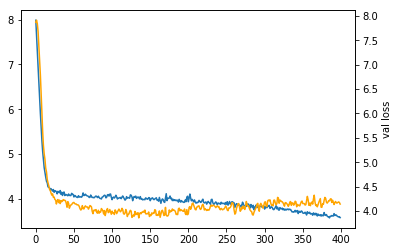

In [102]:
fig, ax1 = plt.subplots()
_ = ax1.plot(history.history['loss'])
ax2 = ax1.twinx()
_ = ax2.plot(history.history['val_loss'], c='orange')
ax2.set_ylabel('val loss')

In [103]:
train_predictions = mod.predict(train_features)
test_predictions = mod.predict(test_features)

-2.843894606858421


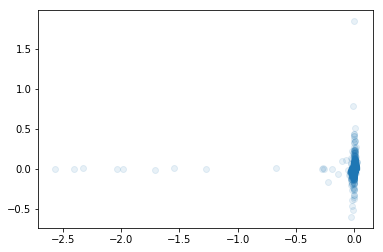

In [104]:
adj_open_f_1_preds = train_predictions[:, 0]
adj_open_f_1_actual = train_targets[:, 0]
print(r2(adj_open_f_1_actual, adj_open_f_1_preds))
_ = plt.scatter(adj_open_f_1_preds, adj_open_f_1_actual, alpha=0.1)

-1.3729217282228996


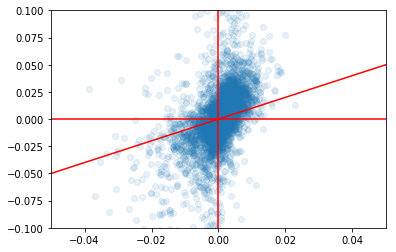

In [112]:
adj_open_f_1_preds = train_predictions[:, 0]
adj_open_f_1_actual = train_targets[:, 1]
print(r2(adj_open_f_1_actual, adj_open_f_1_preds))
_ = plt.scatter(adj_open_f_1_preds, adj_open_f_1_actual, alpha=0.1)
_ = plt.xlim([-0.05, 0.05])
_ = plt.ylim([-0.1, 0.1])
_ = plt.axhline(0, c='r')
_ = plt.axvline(0, c='r')
lines = np.array(range(-26, 26)) / 10
plt.plot(lines, lines, c='r')

0.05216269497938364


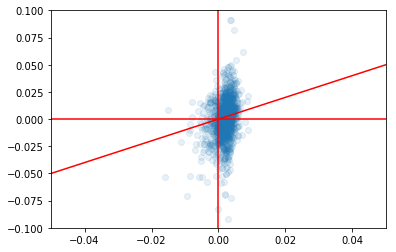

In [113]:
adj_open_f_1_preds = test_predictions[:, 0]
adj_open_f_1_actual = test_targets[:, 1]
print(r2(adj_open_f_1_actual, adj_open_f_1_preds))
_ = plt.scatter(adj_open_f_1_preds, adj_open_f_1_actual, alpha=0.1)
_ = plt.xlim([-0.05, 0.05])
_ = plt.ylim([-0.1, 0.1])
_ = plt.axhline(0, c='r')
_ = plt.axvline(0, c='r')
lines = np.array(range(-26, 26)) / 10
plt.plot(lines, lines, c='r')

# validation is 0.1, so look at just the validation from train, and a similar amount from test

0.12083659308386085


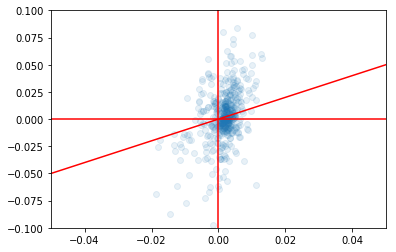

In [114]:
val_size = int(0.1 * train_features.shape[0])

adj_open_f_1_preds = train_predictions[-val_size:, 0]
adj_open_f_1_actual = train_targets[-val_size:, 1]
print(r2(adj_open_f_1_actual, adj_open_f_1_preds))
_ = plt.scatter(adj_open_f_1_preds, adj_open_f_1_actual, alpha=0.1)
_ = plt.xlim([-0.05, 0.05])
_ = plt.ylim([-0.1, 0.1])
_ = plt.axhline(0, c='r')
_ = plt.axvline(0, c='r')
lines = np.array(range(-26, 26)) / 10
plt.plot(lines, lines, c='r')

0.06936773238955707


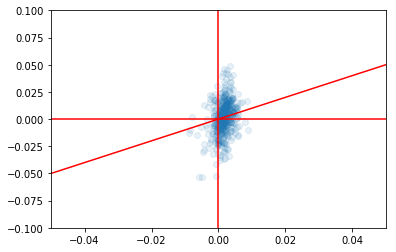

In [115]:
adj_open_f_1_preds = test_predictions[:val_size, 0]
adj_open_f_1_actual = test_targets[:val_size, 1]
print(r2(adj_open_f_1_actual, adj_open_f_1_preds))
_ = plt.scatter(adj_open_f_1_preds, adj_open_f_1_actual, alpha=0.1)
_ = plt.xlim([-0.05, 0.05])
_ = plt.ylim([-0.1, 0.1])
_ = plt.axhline(0, c='r')
_ = plt.axvline(0, c='r')
lines = np.array(range(-26, 26)) / 10
plt.plot(lines, lines, c='r')

In [116]:
val_size

473

In [117]:
test_targets.shape

(1185, 250)

-0.28627278170385373


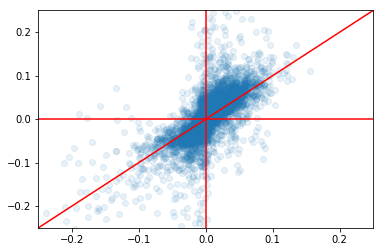

In [118]:
adj_open_f_10_preds = train_predictions[:, 9]
adj_open_f_10_actual = train_targets[:, 9]
print(r2(adj_open_f_10_actual, adj_open_f_10_preds))
_ = plt.scatter(adj_open_f_10_preds, adj_open_f_10_actual, alpha=0.1)
_ = plt.xlim([-0.25, 0.25])
_ = plt.ylim([-0.25, 0.25])
_ = plt.axhline(0, c='r')
_ = plt.axvline(0, c='r')
lines = np.array(range(-26, 26)) / 10
plt.plot(lines, lines, c='r')

-0.1755343353130563


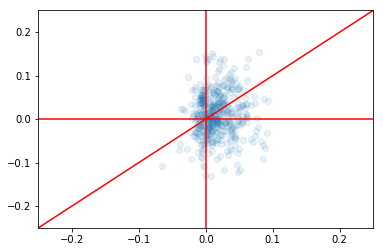

In [119]:
adj_open_f_10_preds = train_predictions[-val_size:, 9]
adj_open_f_10_actual = train_targets[-val_size:, 9]
print(r2(adj_open_f_10_actual, adj_open_f_10_preds))
_ = plt.scatter(adj_open_f_10_preds, adj_open_f_10_actual, alpha=0.1)
_ = plt.xlim([-0.25, 0.25])
_ = plt.ylim([-0.25, 0.25])
_ = plt.axhline(0, c='r')
_ = plt.axvline(0, c='r')
lines = np.array(range(-26, 26)) / 10
plt.plot(lines, lines, c='r')

-0.07182796604159947


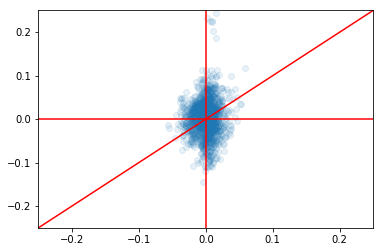

In [120]:
adj_open_f_10_preds = test_predictions[:, 9]
adj_open_f_10_actual = test_targets[:, 9]
print(r2(adj_open_f_10_actual, adj_open_f_10_preds))
_ = plt.scatter(adj_open_f_10_preds, adj_open_f_10_actual, alpha=0.1)
_ = plt.xlim([-0.25, 0.25])
_ = plt.ylim([-0.25, 0.25])
_ = plt.axhline(0, c='r')
_ = plt.axvline(0, c='r')
lines = np.array(range(-26, 26)) / 10
plt.plot(lines, lines, c='r')

In [108]:
for i in range(10):
    print('future period of', str(i + 1), 'r2 of', r2(train_targets[:, i], train_predictions[:, i]))

future period of 1 r2 of -2.843894606858421
future period of 2 r2 of -7.696895563231527
future period of 3 r2 of -0.8806112250038101
future period of 4 r2 of -0.4146970180513332
future period of 5 r2 of -1.661668394826307
future period of 6 r2 of 0.09392252434943205
future period of 7 r2 of -2.588853365514535
future period of 8 r2 of 0.08776817295433736
future period of 9 r2 of -0.3471777516771535
future period of 10 r2 of -0.28627278170385373


-0.3471777516771535


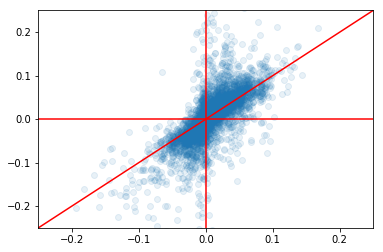

In [109]:
adj_open_f_9_preds = train_predictions[:, 8]
adj_open_f_9_actual = train_targets[:, 8]
print(r2(adj_open_f_9_actual, adj_open_f_9_preds))
_ = plt.scatter(adj_open_f_9_preds, adj_open_f_9_actual, alpha=0.1)
_ = plt.xlim([-0.25, 0.25])
_ = plt.ylim([-0.25, 0.25])
_ = plt.axhline(0, c='r')
_ = plt.axvline(0, c='r')
lines = np.array(range(-26, 26)) / 10
plt.plot(lines, lines, c='r')

# encapsulate feature/target creation into function

In [197]:
# update so both fut and past happen in same iterrows loop
def make_ohlcv_feats_targs(dfs,
                           past_periods=[1, 2, 3, 5, 10, 20, 30, 50, 100],
                           future_days=range(1, 11),
                           verbose=True):
    epsilon = 0.001
    for s in dfs.keys():
        if verbose:
            print(s)
        # create time-lagged percent difference features for OHLCV (and maybe eventually TAs) not bound to a range
        past_cols = ['Adj_Open', 'Adj_Close', 'Adj_High', 'Adj_Low', 'Adj_Volume', 'typical_price']
        # create future targets for each of future_days
        fut_cols = ['Adj_Open', 'Adj_Close', 'Adj_High', 'Adj_Low', 'Adj_Volume']
        past_pct_change_dict = {}
        fut_pct_change_dict = {}
        for c in past_cols:
            for p in past_periods:
                past_pct_change_dict[c + '_pct_change_p=' + str(p)] = []
        
        for c in fut_cols:
            for f in future_days:
                fut_pct_change_dict[c + '_pct_change_f=' + str(f)] = []

        last_idx = dfs[s].shape[0] - 1
        # need to multithread this
        for i, (index, r) in enumerate(dfs[s].iterrows()):
            for c in past_cols:
                for p in past_periods:
                    if i >= p: # if on day 2 (index 1), then the lag would be current - 0
                        old = dfs[s][c].iloc[i-p] + epsilon
                        new = dfs[s][c].iloc[i]
                        pct_change = (new - old) / old
                        past_pct_change_dict[c + '_pct_change_p=' + str(p)].append(pct_change)
                    else:
                        past_pct_change_dict[c + '_pct_change_p=' + str(p)].append(np.nan)
            for c in fut_cols:
                for f in future_days:
                    if i + f <= last_idx: # if on day 2 (index 1), then the lag would be current - 0
                        old = dfs[s][c].iloc[i] + epsilon
                        new = dfs[s][c].iloc[i + f]
                        pct_change = (new - old) / old
                        fut_pct_change_dict[c + '_pct_change_f=' + str(f)].append(pct_change)
                    else:
                        fut_pct_change_dict[c + '_pct_change_f=' + str(f)].append(np.nan)
        
        # add to dataframe
        dfs[s] = dfs[s].assign(**past_pct_change_dict)
        dfs[s] = dfs[s].assign(**fut_pct_change_dict)

        dfs[s].drop(past_cols, inplace=True, axis=1)
        # no need to return anything, all updates made in-place

In [198]:
from concurrent.futures import ProcessPoolExecutor

In [232]:
def make_ohlcv_feats_targs_one(df, past_cols, fut_cols, past_periods, future_days):
    epsilon = 0.001
    past_pct_change_dict = {}
    fut_pct_change_dict = {}
    for c in past_cols:
        for p in past_periods:
            past_pct_change_dict[c + '_pct_change_p=' + str(p)] = []

    for c in fut_cols:
        for f in future_days:
            fut_pct_change_dict[c + '_pct_change_f=' + str(f)] = []

    last_idx = df.shape[0] - 1
    for i, (index, r) in enumerate(df.iterrows()):
        # create time-lagged percent difference features for OHLCV (and maybe eventually TAs) not bound to a range
        for c in past_cols:
            for p in past_periods:
                if i >= p: # if on day 2 (index 1), then the lag would be current - 0
                    old = df[c].iloc[i-p] + epsilon
                    new = df[c].iloc[i]
                    pct_change = (new - old) / old
                    past_pct_change_dict[c + '_pct_change_p=' + str(p)].append(pct_change)
                else:
                    past_pct_change_dict[c + '_pct_change_p=' + str(p)].append(np.nan)
        # create future targets for each of future_days
        for c in fut_cols:
            for f in future_days:
                if i + f <= last_idx: # if on day 2 (index 1), then the lag would be current - 0
                    old = df[c].iloc[i] + epsilon
                    new = df[c].iloc[i + f]
                    pct_change = (new - old) / old
                    fut_pct_change_dict[c + '_pct_change_f=' + str(f)].append(pct_change)
                else:
                    fut_pct_change_dict[c + '_pct_change_f=' + str(f)].append(np.nan)

    # add to dataframe
    df = df.assign(**past_pct_change_dict)
    df = df.assign(**fut_pct_change_dict)
    df.drop(past_cols, inplace=True, axis=1)
    return df

In [233]:
def make_ohlcv_feats_targs_multithread(dfs,
                           past_periods=[1, 2, 3, 5, 10, 20, 30, 50, 100],
                           future_days=range(1, 11),
                           verbose=True,
                           debug=False):
    # columns for past data creation
    past_cols = ['Adj_Open', 'Adj_Close', 'Adj_High', 'Adj_Low', 'Adj_Volume', 'typical_price']
    # columns used for future targets
    fut_cols = ['Adj_Open', 'Adj_Close', 'Adj_High', 'Adj_Low', 'Adj_Volume']
    
    if debug:
        for s in dfs.keys():
            if verbose:
                print(s)
            
            dfs[s] = make_ohlcv_feats_targs_one(dfs[s], past_cols, fut_cols, past_periods, future_days)
            
        return
    
    jobs = []
    with ProcessPoolExecutor(max_workers=None) as executor:
        for s in dfs.keys():
            r = executor.submit(make_ohlcv_feats_targs_one,
                                dfs[s],
                                past_cols,
                                fut_cols,
                                past_periods,
                                future_days)
            jobs.append((s, r))
            if verbose:
                print(s)

    for s, r in jobs:
        res = r.result()
        if res is not None:
            dfs[s] = res
        else:
                print('result is None for', s)

        # no need to return anything, all updates made in-place

In [234]:
def make_multistock_ohlcv_feats_targs(stocks, train_frac=0.8, debug=False):
    # reload data to start from scratch
    dfs, _, _ = dp.load_stocks(stocks=stocks,
                               finra_shorts=False,
                               short_interest=False,
                               earliest_date=None,
                               calc_scores=False)

    latest_date = get_latest_earliest_date(dfs)
    for s in dfs.keys():
        # standardize to latest date so they all have the same earliest time
        dfs[s] = dfs[s][dfs[s].index > latest_date]

    drop_cols(dfs)
    make_ohlcv_feats_targs_multithread(dfs, debug=debug)

    # first get features and targets, and future data
    s = list(dfs.keys())[0]
    targ_cols = [c for c in dfs[s].columns if 'f=' in c]
    feat_cols = [c for c in dfs[s].columns if c not in set(targ_cols)]

    feat_labels = []
    targ_labels = []
    features = None
    for s in dfs.keys():
        no_missing = dfs[s].dropna()
        s_features = no_missing[feat_cols]
        feat_labels.extend([s + '_' + c for c in s_features.columns.tolist()])
        s_targets = no_missing[targ_cols]
        targ_labels.extend([s + '_' + c for c in s_targets.columns.tolist()])
        if features is None:
            features = s_features.values
            targets = s_targets.values
        else:
            features = np.hstack((features, s_features))
            targets = np.hstack((targets, s_targets))
    
    train_size = int(features.shape[0] * train_frac)
    train_features = features[:train_size]
    test_features = features[train_size:]
    train_targets = targets[:train_size]
    test_targets = targets[train_size:]
    
    return dfs, train_features, test_features, train_targets, test_targets, feat_labels, targ_labels 

In [310]:
# top_stocks = sorted_old.loc[:2, 'ticker'].tolist() + ['SPY', 'UPRO', 'QQQ', 'TQQQ', 'DIA', 'UBT']
top_stocks = sorted_old.loc[:20, 'ticker'].tolist() + ['SPY']
top_stocks.remove('URI')
top_stocks.remove('MT')
top_stocks.remove('OLED')

In [311]:
top_stocks

['GGP',
 'LNG',
 'AKS',
 'CHK',
 'AMD',
 'CAR',
 'INCY',
 'SIRI',
 'SWKS',
 'MU',
 'NKTR',
 'X',
 'ETFC',
 'FCX',
 'VRX',
 'REGN',
 'WDC',
 'VRTX',
 'SPY']

In [312]:
dfs, _, _ = dp.load_stocks(stocks=top_stocks,
                           finra_shorts=False,
                           short_interest=False,
                           earliest_date=None,
                           calc_scores=False)

get_latest_earliest_date(dfs, verbose=True)

loading stocks...
calculating TAs...
GGP 1993-04-08 00:00:00
LNG 1994-04-04 00:00:00
AKS 1994-03-30 00:00:00
CHK 1993-02-16 00:00:00
AMD 1983-03-21 00:00:00
CAR 1990-01-12 00:00:00
INCY 1993-11-04 00:00:00
SIRI 1994-09-13 00:00:00
SWKS 1984-09-07 00:00:00
MU 1989-05-16 00:00:00
NKTR 1994-05-03 00:00:00
X 1991-04-12 00:00:00
ETFC 1996-08-16 00:00:00
FCX 1995-07-10 00:00:00
VRX 1994-03-30 00:00:00
REGN 1991-04-02 00:00:00
WDC 1987-01-02 00:00:00
VRTX 1991-07-24 00:00:00
SPY 1993-01-29 00:00:00


Timestamp('1996-08-16 00:00:00')

In [313]:
#top_stocks = top_stocks[:2]

result = make_multistock_ohlcv_feats_targs(stocks=top_stocks, debug=False)
dfs, train_features, test_features, train_targets, test_targets, feat_labels, targ_labels = result

loading stocks...
calculating TAs...
GGP
LNG
AKS
CHK
AMD
CAR
INCY
SIRI
SWKS
MU
NKTR
X
ETFC
FCX
VRX
REGN
WDC
VRTX
SPY


In [314]:
train_features.shape

(4256, 2793)

In [315]:
train_targets.shape

(4256, 950)

In [316]:
K.clear_session()

timesteps = 1
input_dim = train_features.shape[1]
output_dim = train_targets.shape[1]

inputs = Input(shape=(timesteps*input_dim, ))
x = BatchNormalization()(inputs)
x = Dense(3000, activation='elu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(2000, activation='elu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(1000, activation='elu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(500, activation='elu')(x)
x = BatchNormalization()(x)
x = Dropout(0.1)(x)
x = Dense(100, activation='elu')(x)
x = BatchNormalization()(x)
x = Dense(output_dim, activation='linear')(x)

mod = Model(inputs, x)
mod.compile(optimizer='adam', loss=stock_loss_mae_arcsinh)

In [317]:
history = mod.fit(train_features,
            train_targets,
            epochs=400,
            validation_split=0.1,
            batch_size=2000)

Train on 3830 samples, validate on 426 samples
Epoch 1/400
3830/3830 [==============================] - 1s 271us/step - loss: 7.1429 - val_loss: 7.1163
Epoch 2/400
3830/3830 [==============================] - 0s 76us/step - loss: 6.7891 - val_loss: 7.1305
Epoch 3/400
3830/3830 [==============================] - 0s 76us/step - loss: 6.3089 - val_loss: 6.8043
Epoch 4/400
3830/3830 [==============================] - 0s 78us/step - loss: 5.7828 - val_loss: 6.1956
Epoch 5/400
3830/3830 [==============================] - 0s 77us/step - loss: 5.2698 - val_loss: 5.7248
Epoch 6/400
3830/3830 [==============================] - 0s 77us/step - loss: 4.8744 - val_loss: 5.3044
Epoch 7/400
3830/3830 [==============================] - 0s 77us/step - loss: 4.6572 - val_loss: 5.0248
Epoch 8/400
3830/3830 [==============================] - 0s 76us/step - loss: 4.5414 - val_loss: 4.8236
Epoch 9/400
3830/3830 [==============================] - 0s 75us/step - loss: 4.4529 - val_loss: 4.6304
Epoch 10/400
383

3830/3830 [==============================] - 0s 76us/step - loss: 3.9695 - val_loss: 3.6720
Epoch 156/400
3830/3830 [==============================] - 0s 78us/step - loss: 4.0249 - val_loss: 3.6318
Epoch 157/400
3830/3830 [==============================] - 0s 76us/step - loss: 3.9489 - val_loss: 3.6111
Epoch 158/400
3830/3830 [==============================] - 0s 77us/step - loss: 3.9644 - val_loss: 3.6247
Epoch 159/400
3830/3830 [==============================] - 0s 75us/step - loss: 3.9912 - val_loss: 3.6029
Epoch 160/400
3830/3830 [==============================] - 0s 74us/step - loss: 3.9851 - val_loss: 3.5634
Epoch 161/400
3830/3830 [==============================] - 0s 76us/step - loss: 3.9533 - val_loss: 3.5578
Epoch 162/400
3830/3830 [==============================] - 0s 76us/step - loss: 3.9399 - val_loss: 3.5608
Epoch 163/400
3830/3830 [==============================] - 0s 73us/step - loss: 3.9633 - val_loss: 3.6044
Epoch 164/400
3830/3830 [==============================] - 0

3830/3830 [==============================] - 0s 76us/step - loss: 3.9395 - val_loss: 3.6874
Epoch 310/400
3830/3830 [==============================] - 0s 75us/step - loss: 3.7894 - val_loss: 3.7002
Epoch 311/400
3830/3830 [==============================] - 0s 75us/step - loss: 3.7916 - val_loss: 3.7056
Epoch 312/400
3830/3830 [==============================] - 0s 77us/step - loss: 3.7856 - val_loss: 3.7394
Epoch 313/400
3830/3830 [==============================] - 0s 77us/step - loss: 3.8076 - val_loss: 3.7472
Epoch 314/400
3830/3830 [==============================] - 0s 75us/step - loss: 3.7987 - val_loss: 3.7600
Epoch 315/400
3830/3830 [==============================] - 0s 75us/step - loss: 3.8610 - val_loss: 3.7752
Epoch 316/400
3830/3830 [==============================] - 0s 76us/step - loss: 3.7843 - val_loss: 3.7735
Epoch 317/400
3830/3830 [==============================] - 0s 75us/step - loss: 3.7954 - val_loss: 3.7536
Epoch 318/400
3830/3830 [==============================] - 0

Text(0,0.5,'val loss')

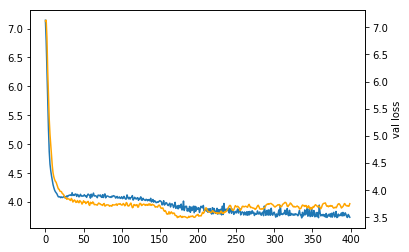

In [318]:
fig, ax1 = plt.subplots()
_ = ax1.plot(history.history['loss'])
ax2 = ax1.twinx()
_ = ax2.plot(history.history['val_loss'], c='orange')
ax2.set_ylabel('val loss')

In [319]:
mod.evaluate(train_features, train_targets)

4256/4256 [==============================] - 0s 116us/step


3.8017513751983643

In [320]:
mod.evaluate(test_features, test_targets)

1065/1065 [==============================] - 0s 118us/step


3.882308393129161

In [321]:
train_predictions = mod.predict(train_features)
test_predictions = mod.predict(test_features)

In [322]:
for i in range(10):
    print('future period of', str(i + 1), 'r2 of', r2(train_targets[:, i], train_predictions[:, i]))

future period of 1 r2 of -0.005429503745955966
future period of 2 r2 of -0.1506111034780484
future period of 3 r2 of 0.008129247133117024
future period of 4 r2 of -0.021491351779697743
future period of 5 r2 of -0.10643979170663931
future period of 6 r2 of -0.00183529284674111
future period of 7 r2 of 0.014830001598273523
future period of 8 r2 of -0.21367941348591923
future period of 9 r2 of 0.019357015543659428
future period of 10 r2 of -0.013825069226739428


In [323]:
targ_labels

['GGP_Adj_Open_pct_change_f=1',
 'GGP_Adj_Open_pct_change_f=2',
 'GGP_Adj_Open_pct_change_f=3',
 'GGP_Adj_Open_pct_change_f=4',
 'GGP_Adj_Open_pct_change_f=5',
 'GGP_Adj_Open_pct_change_f=6',
 'GGP_Adj_Open_pct_change_f=7',
 'GGP_Adj_Open_pct_change_f=8',
 'GGP_Adj_Open_pct_change_f=9',
 'GGP_Adj_Open_pct_change_f=10',
 'GGP_Adj_Close_pct_change_f=1',
 'GGP_Adj_Close_pct_change_f=2',
 'GGP_Adj_Close_pct_change_f=3',
 'GGP_Adj_Close_pct_change_f=4',
 'GGP_Adj_Close_pct_change_f=5',
 'GGP_Adj_Close_pct_change_f=6',
 'GGP_Adj_Close_pct_change_f=7',
 'GGP_Adj_Close_pct_change_f=8',
 'GGP_Adj_Close_pct_change_f=9',
 'GGP_Adj_Close_pct_change_f=10',
 'GGP_Adj_High_pct_change_f=1',
 'GGP_Adj_High_pct_change_f=2',
 'GGP_Adj_High_pct_change_f=3',
 'GGP_Adj_High_pct_change_f=4',
 'GGP_Adj_High_pct_change_f=5',
 'GGP_Adj_High_pct_change_f=6',
 'GGP_Adj_High_pct_change_f=7',
 'GGP_Adj_High_pct_change_f=8',
 'GGP_Adj_High_pct_change_f=9',
 'GGP_Adj_High_pct_change_f=10',
 'GGP_Adj_Low_pct_change_f=

In [324]:
# get SPY close indices
indices = [i for i, t in enumerate(targ_labels) if 'SPY' in t and 'Close' in t]

In [325]:
indices

[910, 911, 912, 913, 914, 915, 916, 917, 918, 919]

In [326]:
np.array(targ_labels)[indices]

array(['SPY_Adj_Close_pct_change_f=1', 'SPY_Adj_Close_pct_change_f=2',
       'SPY_Adj_Close_pct_change_f=3', 'SPY_Adj_Close_pct_change_f=4',
       'SPY_Adj_Close_pct_change_f=5', 'SPY_Adj_Close_pct_change_f=6',
       'SPY_Adj_Close_pct_change_f=7', 'SPY_Adj_Close_pct_change_f=8',
       'SPY_Adj_Close_pct_change_f=9', 'SPY_Adj_Close_pct_change_f=10'],
      dtype='<U31')

-0.013825069226739428


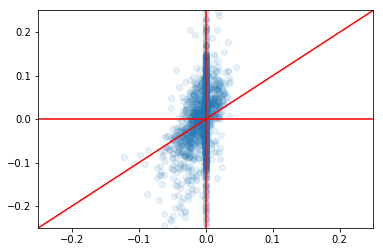

In [327]:
adj_open_f_10_preds = train_predictions[:, 9]
adj_open_f_10_actual = train_targets[:, 9]
print(r2(adj_open_f_10_actual, adj_open_f_10_preds))
_ = plt.scatter(adj_open_f_10_preds, adj_open_f_10_actual, alpha=0.1)
_ = plt.xlim([-0.25, 0.25])
_ = plt.ylim([-0.25, 0.25])
_ = plt.axhline(0, c='r')
_ = plt.axvline(0, c='r')
lines = np.array(range(-26, 26)) / 10
plt.plot(lines, lines, c='r')

0.2623753522440133


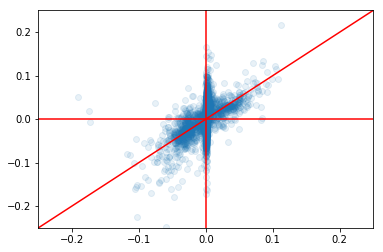

In [328]:
# 10 days future for SPY close
adj_open_f_10_preds = train_predictions[:, indices[-1]]
adj_open_f_10_actual = train_targets[:, indices[-1]]
print(r2(adj_open_f_10_actual, adj_open_f_10_preds))
_ = plt.scatter(adj_open_f_10_preds, adj_open_f_10_actual, alpha=0.1)
_ = plt.xlim([-0.25, 0.25])
_ = plt.ylim([-0.25, 0.25])
_ = plt.axhline(0, c='r')
_ = plt.axvline(0, c='r')
lines = np.array(range(-26, 26)) / 10
plt.plot(lines, lines, c='r')

-7753.474914481471


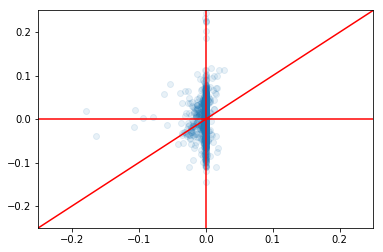

In [329]:
adj_open_f_10_preds = test_predictions[:, 9]
adj_open_f_10_actual = test_targets[:, 9]
print(r2(adj_open_f_10_actual, adj_open_f_10_preds))
_ = plt.scatter(adj_open_f_10_preds, adj_open_f_10_actual, alpha=0.1)
_ = plt.xlim([-0.25, 0.25])
_ = plt.ylim([-0.25, 0.25])
_ = plt.axhline(0, c='r')
_ = plt.axvline(0, c='r')
lines = np.array(range(-26, 26)) / 10
plt.plot(lines, lines, c='r')

# next todo: put functions into .py file
# need to also make way to get predictions for stocks and save them, for live testing/evaluation
# need to make multiple models for stocks with similar start dates
# need to automate finding threshold for predictions
 - safest would be to find the value where all predictions on the train are correct
# automate plotting evaluation (supply stock and property, like close/open)